In [1]:
# Installing packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyomo.environ as pe

# Importing modules for optimizer
from oemof.solph import Bus, Flow, EnergySystem, Model, processing, views
from oemof.solph.components import GenericStorage, Sink, Source, Transformer

#for Optimal Sizing
from oemof.solph import Investment
from oemof.tools import economics

#for emission constraints
from oemof.solph import constraints

# Data Processing

In this section we process our data, so that we can analyze it. We have one dataset with electricity demand, and another dataset with electricity supply from PV. We process each dataset, and then combine them into one dataframe.

### Demand

In [2]:
# Concatinating 30 csv files into one dataframe
location = "/home/bhavya/bg23/aimdes notebooks/Data for project 2 in Tanzania-20230512/Aggregated load data for September/"

files = os.listdir(location)
df = None
for file in files:
    if ".csv" in file:
        #print(file)
        df_inner = pd.read_csv(location + file, delimiter=";")
        day = int(file[file.find("(")+1:file.find(")")])
        df_inner["Day"] = day
        df = pd.concat([df, df_inner])
        
# Adding column names and sorting by day and then time
df.columns = ['Time', 'demand_el', 'Day']
df = df.sort_values(by=["Day", "Time"])
df = df.reset_index(drop=True)

# Aggregating data hourly
df_hour = df.copy()
df_hour['Time'] = pd.to_datetime(df_hour['Time'], format='%H:%M')
df_hour['Time'] = df_hour['Time'].dt.floor('H')
hourly_data = df_hour.groupby(['Day', 'Time'])['demand_el'].sum().reset_index()
hourly_data.rename(columns={'Time': 'Hour'}, inplace=True)

### Supply

In [3]:
# Read the CSV file and skip unwanted rows
df_supply = pd.read_csv("/home/bhavya/bg23/aimdes notebooks/Data for project 2 in Tanzania-20230512/pv.csv", skiprows=3, skipfooter=1, engine='python')

# Cleaning dataframe
df_supply = df_supply.iloc[:, :5]

# Keep only the first 720 rows
df_supply = df_supply.iloc[:720]

# Adding column names
df_supply.columns = ['Time', 'pv', 'Irradiance_direct', 'Irradiance_diffuse', 'Temperature']

# Convert 'Time' to datetime format
df_supply['Time'] = pd.to_datetime(df_supply['Time'])

# Convert columns to numeric format
numeric_columns = ['pv', 'Irradiance_direct', 'Irradiance_diffuse', 'Temperature']
for column in numeric_columns:
    df_supply[column] = pd.to_numeric(df_supply[column], errors='coerce')

### Concatinating data

In [4]:
# Concatinate the supply and demand
data = pd.concat([df_supply, hourly_data], axis=1)

# Drop the specified columns
columns_to_drop = ['Hour', 'Irradiance_diffuse', 'Irradiance_direct', 'Temperature', 'Day']
data = data.drop(columns=columns_to_drop)

data

,Time,pv,demand_el
0,2019-09-01 00:00:00,0.0,3.200
1,2019-09-01 01:00:00,0.0,2.884
2,2019-09-01 02:00:00,0.0,2.784
3,2019-09-01 03:00:00,0.0,2.788
4,2019-09-01 04:00:00,0.0,2.748
...,...,...,...
715,2019-09-30 19:00:00,0.0,10.262
716,2019-09-30 20:00:00,0.0,11.189
717,2019-09-30 21:00:00,0.0,8.664
718,2019-09-30 22:00:00,0.0,7.684


# Timeseries analysis

We start by plotting the raw timeseries of the demand data, where data is recorded every 15 minutes.

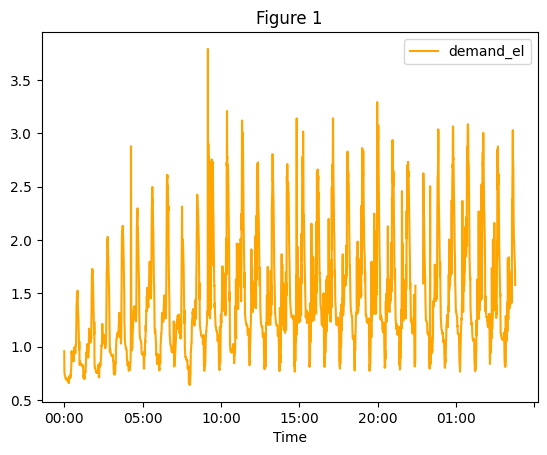

In [5]:
# Plot the line chart
df.plot.line('Time', 'demand_el', color='orange')

# Add a title
plt.title('Figure 1')

# Save the plot as an image
plt.savefig('figure1.png', dpi=300)  # You can choose the file format and resolution you prefer

# Show the plot
plt.show()

We now take a look at the timeseries once demand data is aggregated by the hour.

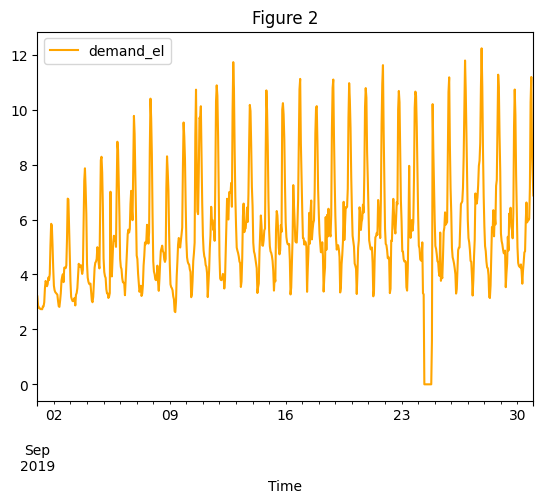

In [6]:
# Plotting hourly data
data.plot.line('Time', 'demand_el', color='orange')

# Add a title
plt.title('Figure 2')

# Save the plot as an image
plt.savefig('figure2.png', dpi=300)  # You can choose the file format and resolution you prefer

# Show the plot
plt.show()

We now move on to the supply of electricity from PV. Again, data is recorded every hour.

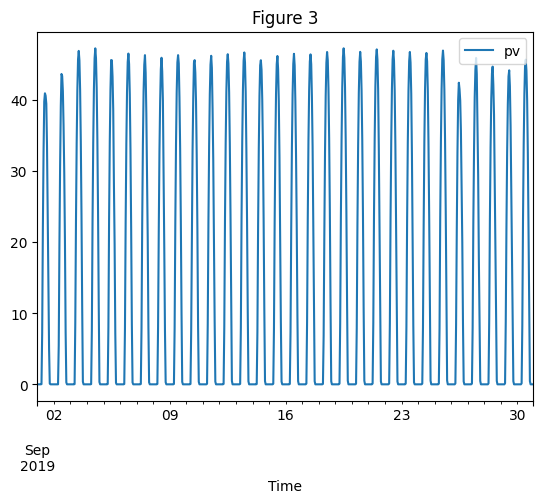

In [7]:
# Plotting hourly data
data.plot.line('Time', 'pv')

# Add a title
plt.title('Figure 3')

# Save the plot as an image
plt.savefig('figure3.png', dpi=300)  # You can choose the file format and resolution you prefer

# Show the plot
plt.show()

We now want to take a look at how demand and supply seems to move when comparing in the same figure.

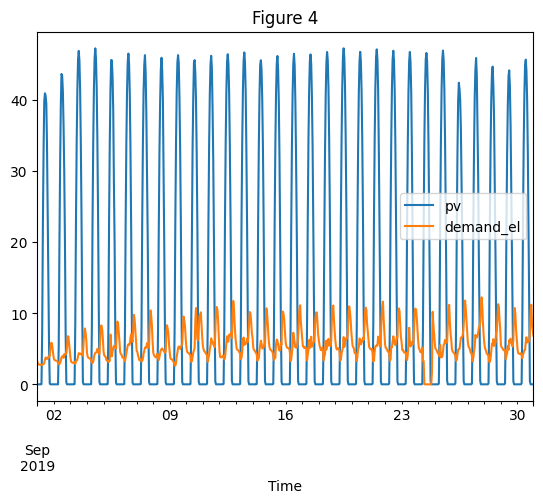

In [8]:
# Plotting hourly data for both 'pv' and 'demand_el'
data.plot.line('Time', ['pv', 'demand_el'])

# Add a title
plt.title('Figure 4')

# Save the plot as an image
plt.savefig('figure4.png', dpi=300)  # You can choose the file format and resolution you prefer

# Show the plot
plt.show()

We now want to zoom in on two seperate days. We choose to look at the coldest and the warmest dates.

In [9]:
# Find the row corresponding to the coldest temperature
coldest_row = df_supply[df_supply['Temperature'] == df_supply['Temperature'].min()]

# Find the row corresponding to the warmest temperature
warmest_row = df_supply[df_supply['Temperature'] == df_supply['Temperature'].max()]

# Extract the date and temperature values
coldest_date = coldest_row['Time'].values[0]
coldest_temperature = coldest_row['Temperature'].values[0]

warmest_date = warmest_row['Time'].values[0]
warmest_temperature = warmest_row['Temperature'].values[0]

# Print the results
print(f"The coldest day is on the date {coldest_date} with a temperature of {coldest_temperature:.2f}.")
print(f"The warmest day is on the date {warmest_date} with a temperature of {warmest_temperature:.2f}.")

The coldest day is on the date 2019-09-09T06:00:00.000000000 with a temperature of 12.57.
The warmest day is on the date 2019-09-30T14:00:00.000000000 with a temperature of 32.69.


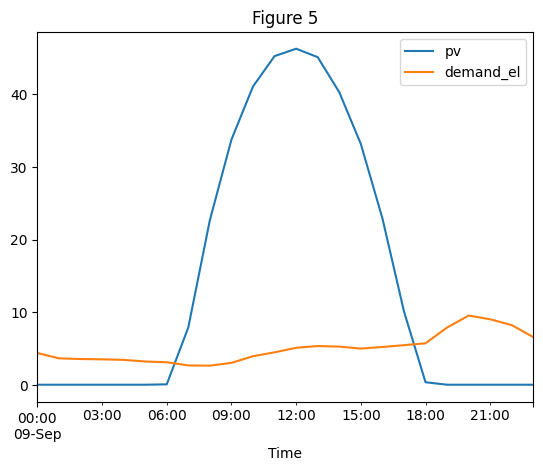

In [10]:
# Choosing the specific day we want to plot
target_day = '2019-09-09'

# Filter data for the chosen day
filtered_data_9 = data[data['Time'].dt.date == pd.to_datetime(target_day).date()]

# Plotting hourly data for both 'pv' and 'demand_el'
filtered_data_9.plot.line('Time', ['pv', 'demand_el'])

# Add a title
plt.title('Figure 5')

# Save the plot as an image
plt.savefig('figure5.png', dpi=300)  # You can choose the file format and resolution you prefer

# Show the plot
plt.show()

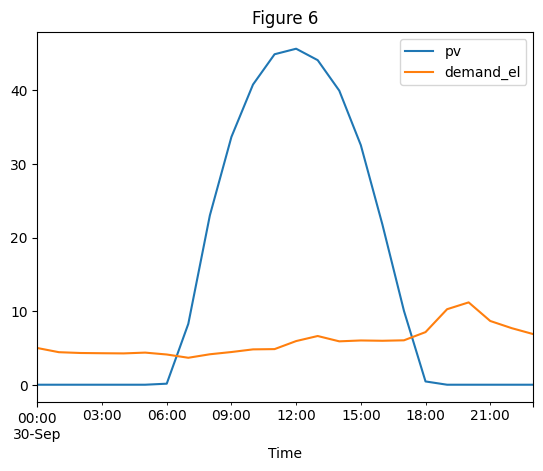

In [11]:
# Choosing the specific day we want to plot
target_day = '2019-09-30'

# Filter data for the chosen day
filtered_data_30 = data[data['Time'].dt.date == pd.to_datetime(target_day).date()]

# Plotting hourly data for both 'pv' and 'demand_el'
filtered_data_30.plot.line('Time', ['pv', 'demand_el'])

# Add a title
plt.title('Figure 6')

# Save the plot as an image
plt.savefig('figure6.png', dpi=300)  # You can choose the file format and resolution you prefer

# Show the plot
plt.show()

We would like to know what the average hourly demand is as we will use it for the optimization problem.

In [12]:
# Calculate average hourly demand
average_hourly_demand_month = data['demand_el'].mean()
print(average_hourly_demand_month)

average_hourly_demand_9 = filtered_data_9['demand_el'].mean()
print(average_hourly_demand_9)

average_hourly_demand_30 = filtered_data_30['demand_el'].mean()
print(average_hourly_demand_30)

5.577388888888889
4.985666666666667
5.8713750000000005


# Optimizing

In this section we optimize the micro-grid using oemof. We start by finding the optimal dispatch. This is done for one single day, for one week and for the entire period. Next, we also optimize for the optimal sizing, using the same three categories of dates.

### Optimal Dispatch: Closed Market

First, we try solving the closed market using Oemof.

In [13]:
# Parameters based on the provided information

#Battery
nominal_battery_capacity = 310  # kwh
max_inverter_power_input = 49  # kw
max_soc = 0.9  # 90% state of charge
min_soc = 0.4  # 40% state of charge
initial_soc = 0.7  # 70% initial state of charge
self_discharge_rate = 0  # 0% self discharge rate

#PV
max_pv_inverter_power_input = 60  # kW

# Diesel genset
genset_power = 27  # kW

# Demand
average_energy_demand_month = 5.57738888888889
average_energy_demand_9 = 4.985666666666667
average_energy_demand_week = 5.3

# I choose the specific day that I want to optimize over
target_day_9 = '2019-09-09'
filtered_data_9 = data[data['Time'].dt.date == pd.to_datetime(target_day_9).date()]

# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-09', periods=1*24, freq='H')
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=True)
filtered_data_9.index = datetimeindex

# Electricity bus
bus_el = Bus(label='electricity')

# Diesel bus
bus_diesel = Bus(label='diesel_bus')

# Diesel bus
diesel = Source(label='diesel', outputs={bus_el: Flow(variable_costs=0.02*1e6, nominal_value=genset_power)}) # EUR/GWh


# Diesel genset
diesel_genset = Transformer(label='diesel_genset',
                      inputs={bus_diesel: Flow()},
                      outputs={bus_el: Flow(nominal_value=genset_power)},
                      conversion_factors={bus_el: 0.70}) # Efficiency


# PV source
pv = Source(label='pv', outputs={bus_el: Flow(fix=filtered_data_9['pv'],
                                              nominal_value=max_pv_inverter_power_input)}) 
# Sinks
demand_el = Sink(label='demand_el',
                 inputs={bus_el: Flow(nominal_value=average_energy_demand_9,
                                         fix=filtered_data_9['demand_el'],
                                         )})

# Storage
storage_el = GenericStorage(label='storage_el',
                            nominal_storage_capacity=nominal_battery_capacity,
                            inputs={bus_el: Flow(nominal_value=max_inverter_power_input)}, # this is our G_r
                            outputs={bus_el: Flow(nominal_value=max_inverter_power_input)}, #
                            loss_rate=self_discharge_rate, 
                            initial_storage_level=initial_soc,
                            max_storage_level=max_soc,
                            inflow_conversion_factor=1,
                            outflow_conversion_factor=1)

# Adding above created variables/functions to the oemof model:
energysystem.add(bus_el, bus_diesel,
                 diesel, diesel_genset,
                 pv, demand_el, 
                 storage_el)

# Create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# Solve problem
optimization_model.solve(solver='glpk')

/home/bhavya/anaconda3/lib/python3.10/site-packages/oemof/solph/_models.py:257: UserWarning: Optimization ended with status ok and termination condition infeasible
  warnings.warn(


{'Problem': [{'Name': 'unknown', 'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 97, 'Number of variables': 144, 'Number of nonzeros': 264, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'infeasible', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.007279634475708008}]}

Since the solution is unfeasible using Oemof, we try solve it "manually" using Pyomo.

In [14]:
# Choosing specific day to optimize over
target_day_9 = '2019-09-15'
filtered_data_9 = data[data['Time'].dt.date == pd.to_datetime(target_day_9).date()]
filtered_data_9.reset_index(drop=True, inplace=True)

In [15]:
# Capacities (kW) for different technologies
capacities = {
    "PV": 60,
    "Diesel": 29
}

# Marginal costs (EUR/kWh) for different technologies
marginal_costs = {
    "PV": 0,
    "Diesel": 0.02
}

# PV supply data
PV_ts = filtered_data_9['pv']

# Demand data
load = filtered_data_9['demand_el']

# Create ConcreteModel
m = pe.ConcreteModel()

# Sets for technologies and time periods
m.S = pe.Set(initialize=capacities.keys())
m.T = pe.RangeSet(24)  # Assuming 24 time periods

# Decision variable for generation
m.g = pe.Var(m.S, m.T, within=pe.NonNegativeReals)

# Objective function: total cost
m.cost = pe.Objective(expr=sum(marginal_costs[s] * m.g[s, t] for s in m.S for t in m.T))

# Storage parameters
storage_energy = 310  # kWh
storage_power = 49  # kW
efficiency = 0.9  # discharge = charge
standing_loss = 0  # per hour
min_soc = 0.4  # Minimum SOC percentage
max_soc = 0.9  # Maximum SOC percentage
initial_soc = 0.7  # Initial SOC percentage

# Storage constraints
m.discharge = pe.Var(m.T, bounds=(0, storage_power))
m.charge = pe.Var(m.T, bounds=(0, storage_power))
m.soc = pe.Var(m.T, bounds=(min_soc * storage_energy, max_soc * storage_energy))

# Initial SOC constraint
m.initial_soc_constraint = pe.Constraint(expr=m.soc[1] == initial_soc * storage_energy)

# Storage constraint
@m.Constraint(m.T)
def storage_consistency(m, t):
    if t == 1:
        return m.soc[t] == initial_soc * storage_energy
    return m.soc[t] == (1 - standing_loss) * m.soc[t-1] + efficiency * m.charge[t] - 1 / efficiency * m.discharge[t]

# Capacity constraints for generators
@m.Constraint(m.S, m.T)
def generator_limit(m, s, t):
    if s == "PV":
        return m.g[s, t] <= PV_ts[t-1]
    else:
        return m.g[s, t] <= capacities[s]

# Energy balance constraints
@m.Constraint(m.T)
def energy_balance(m, t):
    return sum(m.g[s, t] for s in m.S) + m.discharge[t] - m.charge[t] == load[t - 1] - filtered_data_9['pv'][t - 1]

In [16]:
# Solve the optimization problem
solver = pe.SolverFactory('glpk')
results = solver.solve(m)

In [17]:
# Check the solver status
if results.solver.termination_condition == pe.TerminationCondition.optimal:
    # Access the variable values
    generation_values = {(s, t): m.g[s, t].value for s in m.S for t in m.T}
    battery_discharge_values = {t: m.discharge[t].value for t in m.T}
    battery_charge_values = {t: m.charge[t].value for t in m.T}
    soc_values = {t: m.soc[t].value for t in m.T}

    # Print or analyze the solution values as needed
    print("Generation values:", generation_values)
    print("Battery discharge values:", battery_discharge_values)
    print("Battery charge values:", battery_charge_values)
    print("SOC values:", soc_values)
else:
    print("Solver did not converge to an optimal solution.")

Solver did not converge to an optimal solution.


In [18]:
pe.SolverFactory('glpk').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 97
  Number of variables: 120
  Number of nonzeros: 238
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: other
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.00502467155456543


Using Pyomo "manually" also does not provide us with a solution. Hence, we conclude that it is not the solver which is the problem, but instead the closed market: we need an excess sink, or export option. Thus, in the next section we move on to analyzing the open market.

### Optimal Dispatch: Open Market

In [19]:
# Parameters based on the provided information

#Battery
# The nominal battery capacity is important for determining the total amount of energy that a battery can store.
nominal_battery_capacity = 310  # kwh

# The max inverter power input is important for determining the maximum rate at which a battery can be charged.
max_inverter_power_input = 49  # kw
max_soc = 0.9  # 90% state of charge
min_soc = 0.4  # 40% state of charge
initial_soc = 0.7  # 70% initial state of charge
self_discharge_rate = 0  # 0% self discharge rate

#PV
max_pv_inverter_power_input = 60  # kW

# Diesel genset
genset_power = 27  # kW

# which solver to use
solver = 'glpk' 
#solver = 'gurobi' 

In [20]:
class MyEnergySystemModel:
    
    def __init__(
        self,
        filtered_data,
        average_energy_demand,
        fuel_cost=0.2,
        investment_diesel=None,
        investment_pv=None,
        investment_battery=None,
        custom_attributes=None,
        emission_limit=None):
        
        self.filtered_data = filtered_data
        self.average_energy_demand = average_energy_demand
        self.fuel_cost = fuel_cost
        
        # for optimal sizing
        self.investment_diesel = investment_diesel
        self.investment_pv = investment_pv
        self.investment_battery = investment_battery
        
        #for emission constraints
        self.custom_attributes = custom_attributes
        self.emission_limit = emission_limit
        
        self.setup_components()


    def setup_components(self):
        # Diesel bus
        self.bus_diesel = Bus(label='diesel_bus')

        # Electricity bus
        self.bus_el = Bus(label='electricity')

        # Define your energy carrier sources, including their per-unit costs:
        self.source_diesel = Source(
            label='source_diesel',
            outputs={
                self.bus_diesel: Flow(
                    variable_costs=self.fuel_cost,    # USD/KWh
                    custom_attributes=self.custom_attributes
                )
            }
        )

        # Diesel component
        self.diesel = Transformer(
            label="diesel_genset",
            inputs={self.bus_diesel: Flow()},
            outputs={
                self.bus_el: Flow(
                    investment = self.investment_diesel,
                    # Using the investment object the nominal_value has to be set to None.
                    nominal_value=None if self.investment_diesel is not None else genset_power)},
            
            # Efficiency source - https://reiner-lemoine-institut.de/wp-content/publications/Battery_TZA/2015-en-battery-storage-tanzania.pdf
            conversion_factors={self.bus_el: 0.3}  
        )

        # PV source
        self.pv = Source(
            label='pv',
            outputs={
                self.bus_el: Flow(
                    investment = self.investment_pv,
                    fix=self.filtered_data['pv'],
                    nominal_value=None if self.investment_pv is not None else max_pv_inverter_power_input
                )
            }
        ) 

        # Create the GenericStorage instance with the provided details
        self.battery = GenericStorage(
            label='battery',
            nominal_storage_capacity=nominal_battery_capacity,
            inputs={self.bus_el: Flow(nominal_value=max_inverter_power_input)}, # this is our G_r
            outputs={
                self.bus_el: Flow(
                    investment = self.investment_battery,
                    nominal_value=None if self.investment_battery is not None else max_inverter_power_input
                )
            }, 
            loss_rate=self_discharge_rate, 
            initial_storage_level=initial_soc,
            max_storage_level=max_soc,
            inflow_conversion_factor=1,
            outflow_conversion_factor=1
        )
        
        # Sinks
        self.demand_el = Sink(label='demand_el',
                         inputs={self.bus_el: Flow(nominal_value=self.average_energy_demand,
                                                 fix=self.filtered_data['demand_el'],
                                                 )})

        self.excess_el = Sink(label='excess_el', inputs={self.bus_el: Flow()})

        self.shortage_el = Source(label='shortage_el',
                             outputs={self.bus_el: Flow(variable_costs=1e15)})
        
        # Adding above created variables/functions to the oemof model:
        energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=True)

        # Adding above created variables/functions to the oemof model:
        energysystem.add(self.bus_diesel,
                         self.bus_el,
                         self.source_diesel,
                         self.diesel,
                         self.pv, 
                         self.demand_el, 
                         self.battery,
                         self.excess_el,
                         self.shortage_el)

        # Create optimization model based on energy_system
        optimization_model = Model(energysystem=energysystem)
        
        # Add the emission constraint only if the emission_limit parameter is provided
        if self.emission_limit is not None:
            constraints.emission_limit(optimization_model, limit=self.emission_limit)

        # Solve problem
        optimization_model.solve(solver=solver)

        # Get results
        self.results_main = processing.results(optimization_model)
        results_meta = processing.meta_results(optimization_model)
        params = processing.parameter_as_dict(energysystem)
        
        if self.investment_diesel is not None and self.investment_pv is not None and self.investment_battery is not None:

            results_el = views.node(self.results_main, 'electricity')

            el_sequences = results_el['sequences']

            to_el = {key[0][0]: key for key in el_sequences.keys() if key[0][1] == 'electricity' and key[1] == 'flow'}
            to_el = [to_el.pop('pv'), to_el.pop('battery')] + list(to_el.values())
            el_prod = el_sequences[to_el]

            fig, ax = plt.subplots(figsize=(14, 6))
            el_prod.plot.area(ax=ax)
            el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
            el_sequences[(('electricity', 'excess_el'), 'flow')].plot(ax=ax, linewidth=3)
            legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot
            plt.savefig('sizing_dispatch.png', dpi=1000)

            cap_diesel = results_el['scalars'][(('diesel_genset', 'electricity'), 'invest')]
            cap_pv = results_el['scalars'][(('pv', 'electricity'), 'invest')]
            cap_battery = results_el['scalars'][(('battery', 'electricity'), 'invest')]
            print('Capacity diesel: ' + str(cap_diesel) + ' \nCapacity pv: ' + str(cap_pv)+ ' \nCapacity battery: ' + str(cap_battery))

    
        
                
    # Plot electricity flows in system
    def plot_electricity_flows(self):
        flows_el=pd.DataFrame(index=datetimeindex)
        flows_el['PV'] = self.results_main[self.pv, self.bus_el]['sequences']
        flows_el['Diesel'] = self.results_main[self.diesel, self.bus_el]['sequences']
        flows_el['Battery'] = self.results_main[(self.battery, self.bus_el)]['sequences']
        flows_el['Excess'] = self.results_main[self.bus_el, self.excess_el]['sequences']
        flows_el['Shortage'] = self.results_main[self.shortage_el, self.bus_el]['sequences']
        flows_el['Total'] = flows_el.sum(axis=1)

        flows_el_percentage=pd.DataFrame(index=datetimeindex)

        for column in flows_el.columns:
            if column != 'Total':
                flows_el_percentage[column]=flows_el[column]/flows_el['Total']

        flows_el_percentage.plot.area()

#### For one day

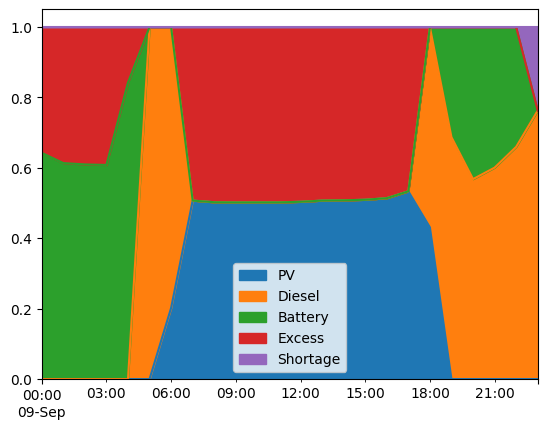

In [21]:
# I choose the specific day that I want to optimize over
target_day_9 = '2019-09-09'
filtered_data_9 = data[data['Time'].dt.date == pd.to_datetime(target_day_9).date()]

# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-09', periods=1*24, freq='H')
filtered_data_9.index = datetimeindex

# Demand
average_energy_demand_9 = 4.985666666666667

energy_system_model = MyEnergySystemModel(filtered_data = filtered_data_9, average_energy_demand = average_energy_demand_9)


energy_system_model.plot_electricity_flows()
plt.savefig('electricity_flows_1_day.png', dpi=1000)

#### For one week

In this section i oprimize over one random week. I select the first week, that is from 1st of September to 7th of September.

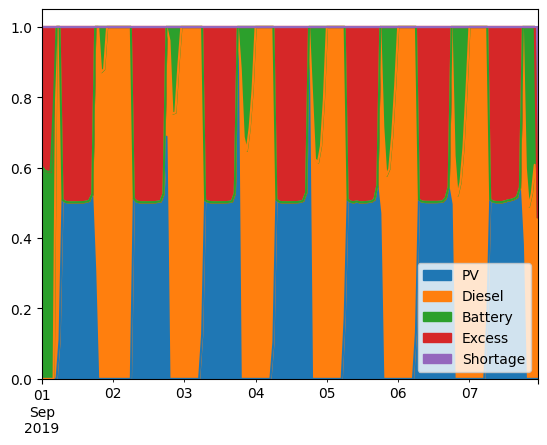

In [22]:
# Subsetting data to contain the first week
start_date = '2019-09-01 00:00:00'
end_date = '2019-09-07 23:00:00'
subset_data = data.loc[(data['Time'] >= start_date) & (data['Time'] <= end_date)]

# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-01', periods=7*24, freq='H')
subset_data.index = datetimeindex

# Demand
average_energy_demand_week = 5.3

energy_system_model = MyEnergySystemModel(filtered_data = subset_data, average_energy_demand = average_energy_demand_week)

energy_system_model.plot_electricity_flows()
plt.savefig('electricity_flows_1_week.png', dpi=1000)

#### The entire period

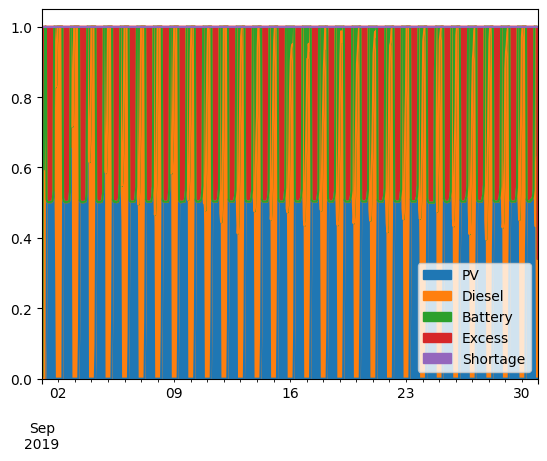

In [23]:
# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-01', periods=30*24, freq='H')
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=True)
data.index = datetimeindex

# Demand
average_energy_demand_month = 5.57738888888889

energy_system_model = MyEnergySystemModel(filtered_data = data, average_energy_demand = average_energy_demand_month)

energy_system_model.plot_electricity_flows()
plt.savefig('electricity_flows_1_month.png', dpi=1000)

Now we move on to the optimal sizing considering existing installed capacities as 0

### Optimal sizing 

In [24]:
# For optimal sizing

# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-01', periods=30*24, freq='H')
duration_hours = len(datetimeindex)

# Below, cost_ratio_timeinterval is calculated as the ratio of the duration of the data (in hours) to the total number of hours in a year (365 days * 24 hours/day). This ratio represents the fraction of a year that the provided data covers, and it's used to convert the annualized costs into costs appropriate for the time interval of your modeling.

cost_ratio_timeinterval = duration_hours/(365*24)

# Equivalent Present Cost (EPC) for Coal Power Plant Investment per Year or EAC (Equivalent Annual Cost)

# wacc and n source - https://www.irena.org/-/media/Files/IRENA/Agency/Events/2014/Jul/15/15_Economic_assessment_of_PV_and_wind_for_energy_planning_Arusha_Tanzania.pdf?la=en&hash=ED061A535145DD86023F615866220C220B601FFC

#investment costs - taken from table by marius

epc_diesel = economics.annuity(capex=20000, n=20, wacc=0.08)*cost_ratio_timeinterval
epc_pv = economics.annuity(capex=56820, n=20, wacc=0.08)*cost_ratio_timeinterval
epc_battery = economics.annuity(capex=223221, n=20, wacc=0.08)*cost_ratio_timeinterval

Capacity diesel: 111.405404277778 
Capacity pv: 8.01516430387173 
Capacity battery: 183.624904888889


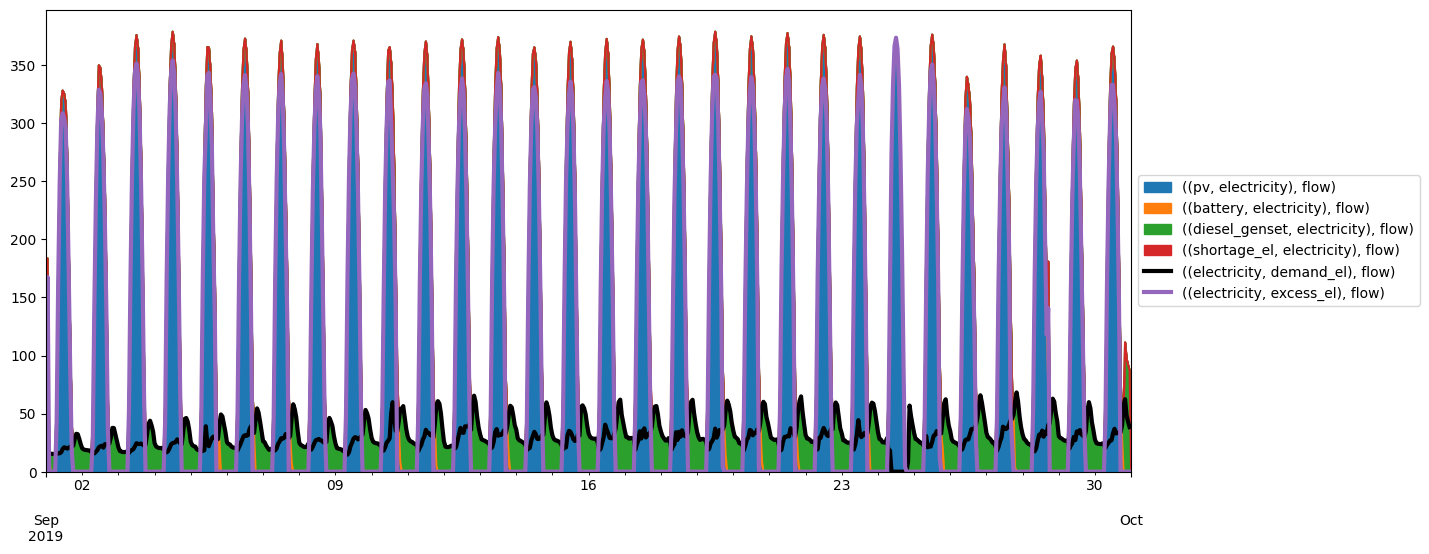

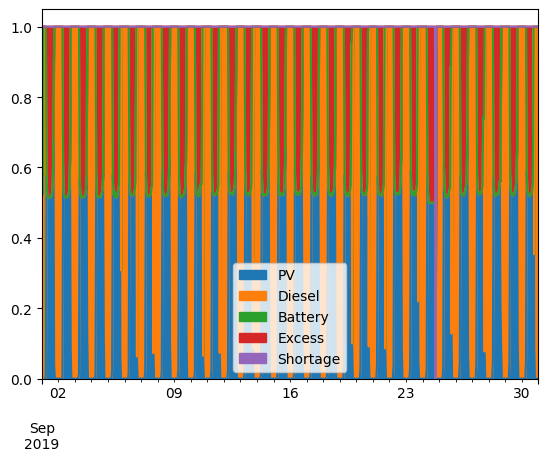

In [25]:
#very high maximum allowable value for investment (maximum=5e9)

#currently installed value = genset_power
investment_diesel = Investment(ep_costs=epc_diesel,maximum=5e9, existing=0) #currently installed value = genset_power
#currently installed value = max_pv_inverter_power_input
investment_pv = Investment(ep_costs=epc_pv,maximum=5e9, existing=0)
#currently installed value = nominal_battery_capacity
investment_battery = Investment(ep_costs=epc_battery,maximum=5e9, existing=0)

energy_system_model = MyEnergySystemModel(
    filtered_data = data,
    average_energy_demand = average_energy_demand_month, 
    investment_diesel = investment_diesel, 
    investment_pv = investment_pv, 
    investment_battery = investment_battery)

energy_system_model.plot_electricity_flows()

### Optimal Sizing (with Emission Constraints)

We now consider optimal sizing with the same parameters as above, but 2 additional parameters which are emission_factor for diesel_genset and a emission limit constraint

Capacity diesel: 4.2774395042735 
Capacity pv: 607.39564157706 
Capacity battery: 137.488744


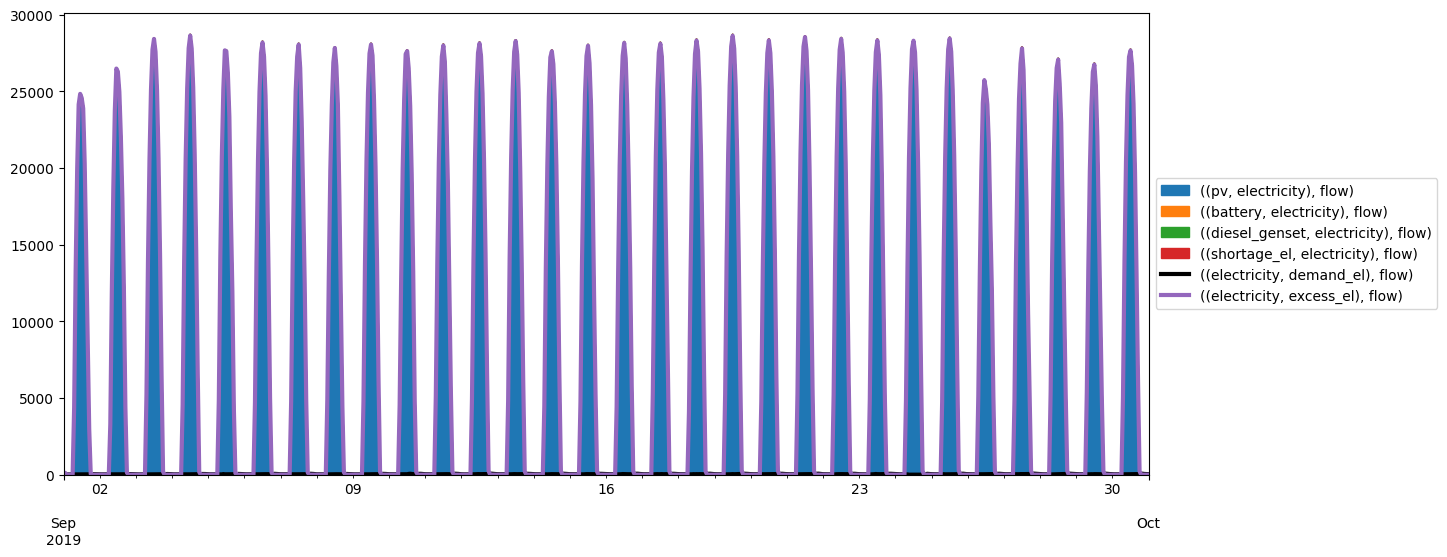

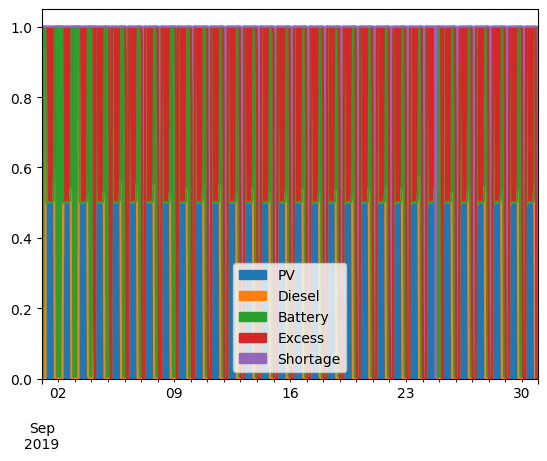

In [26]:
#The emission factor is a measure of the amount of CO2 emissions produced by the diesel generator per kwh of energy generated.

# source: (table 5)https://www.umweltbundesamt.de/sites/default/files/medien/378/publikationen/annex_i_standardized_baselines_and_their_implications_for_a_national.pdf

custom_attributes_diesel={"emission_factor": 1.3}

energy_system_model = MyEnergySystemModel(
    filtered_data = data, 
    average_energy_demand = average_energy_demand_month, 
    investment_diesel = investment_diesel, 
    investment_pv = investment_pv, 
    investment_battery = investment_battery,
    custom_attributes = custom_attributes_diesel, 
    # 20 tonnes/MWh of CO2 per day
    emission_limit=20)

energy_system_model.plot_electricity_flows()
plt.savefig('electricity_flows_emission_constraints.png', dpi=1000)

# Sensitivity Analysis

#### Marginal prices change

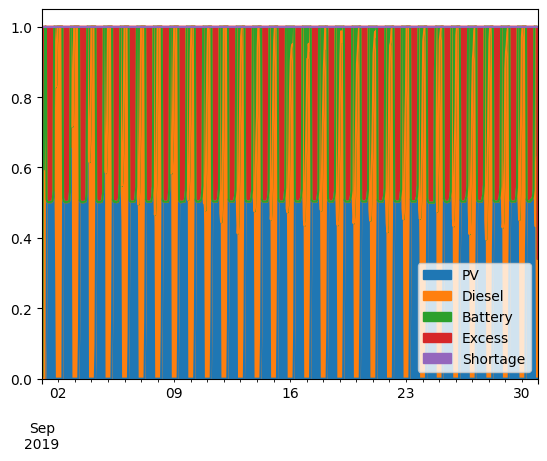

In [27]:
#Of the many potential input values, rising cost for operating the diesel generator, may it be through
# rising cost of repairs and maintenance or through a rise of diesel fuel prices is a realistic scenario.
# Therefore the system was run with a marginal cost of $0.04, a 100% increase over the original cost.
# However, changing the prices lead to no change in optimal dispatch, which was the expected solution, as there 
# is no viable alternative in our mini grid to using the diesel generator, meaning the only alternative is a
# shortage. Unless the price for diesel fuel rises above the price for a shortage, optimal dispatch shall not
# change 

# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-01', periods=30*24, freq='H')
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=True)
data.index = datetimeindex

# Demand
average_energy_demand_month = 5.57738888888889

energy_system_model = MyEnergySystemModel(
    filtered_data = data, 
    average_energy_demand = average_energy_demand_month, 
    fuel_cost = 0.04
)

energy_system_model.plot_electricity_flows()

Capacity diesel: 111.405404277778 
Capacity pv: 8.01516430387173 
Capacity battery: 183.624904888889


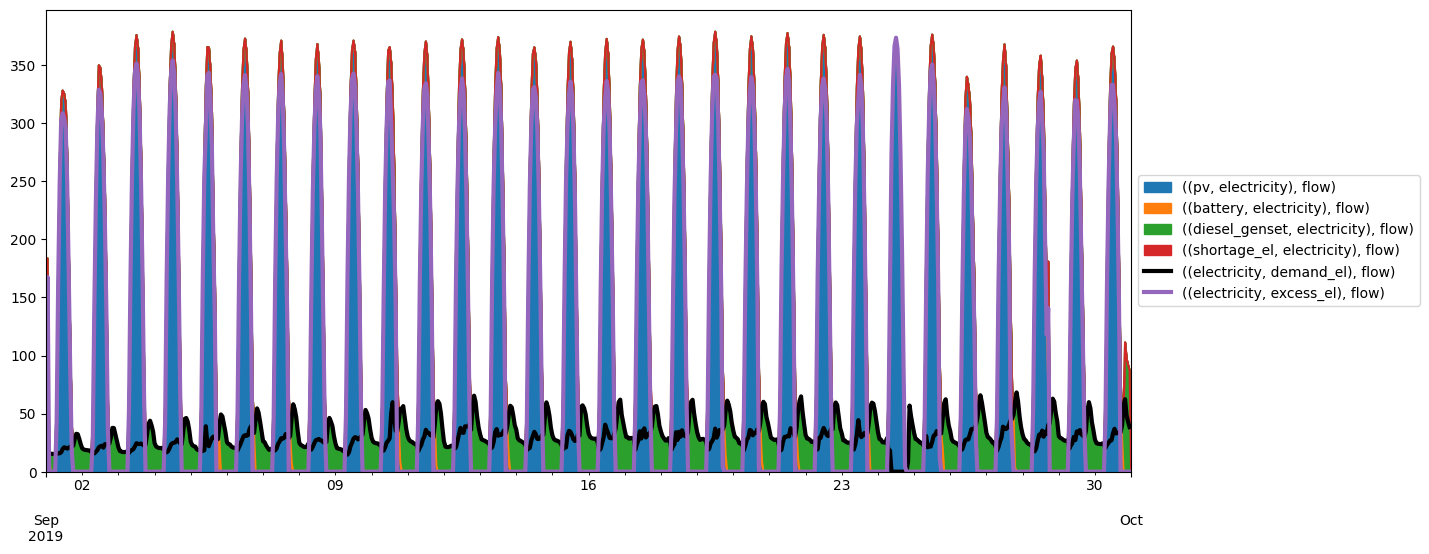

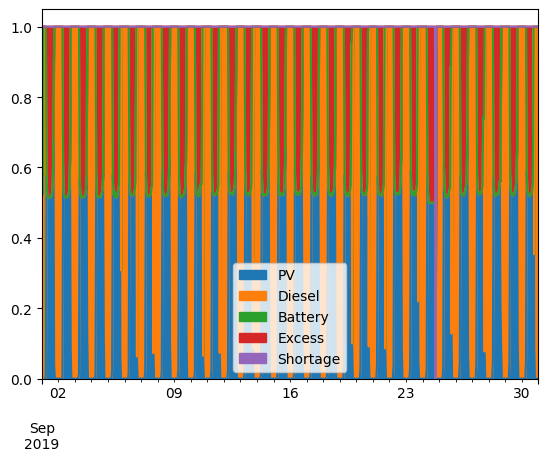

In [28]:
# The results of the doubled marginal cost for the diesel genset is similar to that of the optimal dispatch, 
# at this level, there is no measurable influence. 

energy_system_model = MyEnergySystemModel(
    filtered_data = data,
    average_energy_demand = average_energy_demand_month,
    fuel_cost = 0.04,
    investment_diesel = investment_diesel, 
    investment_pv = investment_pv, 
    investment_battery = investment_battery)

energy_system_model.plot_electricity_flows()

#### Change of battery capacity

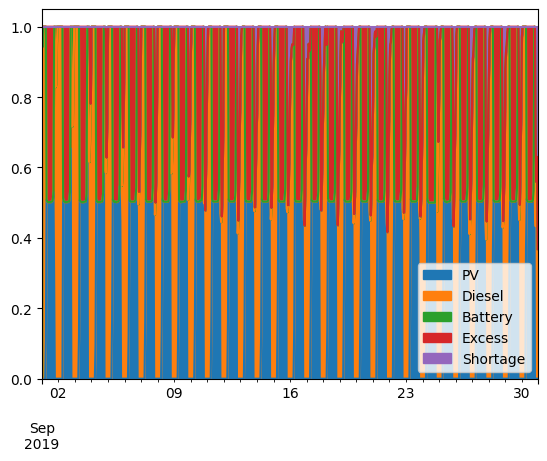

In [29]:
# In this case, while keeping all other paramters constant, we are assuming a much smaller battery than in
# initial setting. While the original battery capacity was at 310kWh, in this case it at only 50kWh, a 
# potential scenario for this would be a system in which the battery is nearing the end of its life and has 
# massively degenerated. In this scenario, shortages start to occur as the battery capacity is insufficient for
# the demand. 



# Parameters based on the provided information

#Battery
# The nominal battery capacity is important for determining the total amount of energy that a battery can store.
nominal_battery_capacity = 50  # kwh
# The max inverter power input is important for determining the maximum rate at which a battery can be charged.
max_inverter_power_input = 49  # kw
max_soc = 0.9  # 90% state of charge
min_soc = 0.4  # 40% state of charge
initial_soc = 0.7  # 70% initial state of charge
self_discharge_rate = 0  # 0% self discharge rate

#PV
max_pv_inverter_power_input = 60  # kW

# Diesel genset
genset_power = 27  # kW

# which solver to use
solver = 'glpk' 
#solver = 'gurobi' 

# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-01', periods=30*24, freq='H')
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=True)
data.index = datetimeindex

# Demand
average_energy_demand_month = 5.57738888888889

energy_system_model = MyEnergySystemModel(
    filtered_data = data, 
    average_energy_demand = average_energy_demand_month, 
    fuel_cost = 0.04
)

energy_system_model.plot_electricity_flows()

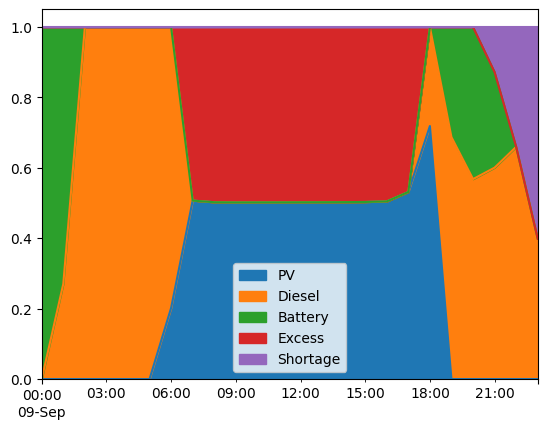

In [30]:
# Looking at a specific day, with reduced battery capacity, it can be seen that the diesel generator is
# increasingly used and usage of the battery is reduced outsdie of PV peak hours. The optimal dispatch also 
# shows a shortage at the end of the day


# I choose the specific day that I want to optimize over
target_day_9 = '2019-09-09'
filtered_data_9 = data[data['Time'].dt.date == pd.to_datetime(target_day_9).date()]

# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-09', periods=1*24, freq='H')
filtered_data_9.index = datetimeindex

# Demand
average_energy_demand_9 = 4.985666666666667

energy_system_model = MyEnergySystemModel(filtered_data = filtered_data_9, average_energy_demand = average_energy_demand_9,  fuel_cost = 0.02)


energy_system_model.plot_electricity_flows()
plt.savefig('electricity_flows_1_day.png', dpi=1000)

#### Change of pv input

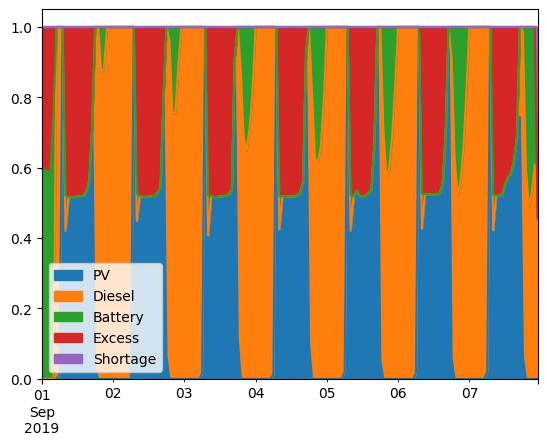

In [31]:
# As previous calculations showed the optimal sizing for the PV to be around 8kW, while keeping all other
# parameters constant, we reduced max PV input for one week to only 7kW, down from 60kW before.
# While the difference is not enormous, it can certainly be observed that a higher diesel generator output
# has become necessary to fulfil demand, which was expected, as the capacity is below the optimal capacity. 
# A possible scenario for this could be a flood in the region that renders most of the PV panels in a state
# of repair.

# Parameters based on the provided information

#Battery
# The nominal battery capacity is important for determining the total amount of energy that a battery can store.
nominal_battery_capacity = 310  # kwh
# The max inverter power input is important for determining the maximum rate at which a battery can be charged.
max_inverter_power_input = 49  # kw
max_soc = 0.9  # 90% state of charge
min_soc = 0.4  # 40% state of charge
initial_soc = 0.7  # 70% initial state of charge
self_discharge_rate = 0  # 0% self discharge rate

#PV
max_pv_inverter_power_input = 7  # kW

# Diesel genset
genset_power = 27  # kW

# which solver to use
solver = 'glpk' 
#solver = 'gurobi' 

# Subsetting data to contain the first week
start_date = '2019-09-01 00:00:00'
end_date = '2019-09-07 23:00:00'
subset_data = data.loc[(data['Time'] >= start_date) & (data['Time'] <= end_date)]

# The oemof energy system model (optimizer) has to be initalized with a pandas datetimeindex:
datetimeindex = pd.date_range('2019-09-01', periods=7*24, freq='H')
subset_data.index = datetimeindex

# Demand
average_energy_demand_week = 5.3

energy_system_model = MyEnergySystemModel(filtered_data = subset_data, average_energy_demand = average_energy_demand_week, fuel_cost = 0.02)

energy_system_model.plot_electricity_flows()